In [ ]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. The variable selection problem in MMM's

In [ ]:
dates = pd.date_range(start="2021-06-07", periods=52*3, freq="W")

**Generate data**

In [ ]:
seasonal_year_pattern = np.transpose([[1,1.25,0.75, 1]]*13).flatten()
seasonal_pattern = np.stack([seasonal_year_pattern, seasonal_year_pattern, seasonal_year_pattern] ).flatten()
football_worldcup_campaign = np.concatenate([np.repeat(0, 65), np.repeat(1, 13), np.repeat(0,52*3 -13-65)])
Q1 = np.transpose([[1,0,0, 0]]*13).flatten()
Q1_dummy = np.stack([Q1, Q1, Q1]).flatten()
Q2 = np.transpose([[0,1,0, 0]]*13).flatten()
Q2_dummy = np.stack([Q2, Q2, Q2]).flatten()
Q3 = np.transpose([[0,0,1, 0]]*13).flatten()
Q3_dummy = np.stack([Q3, Q3, Q3]).flatten()

In [ ]:
price_index = np.random.normal(1, 0.1, 3*52)
instagram_c = np.random.normal(1.25*10e5, 5*10e4, 3*52)*seasonal_pattern + 0.25*10e5*football_worldcup_campaign + 1*10e5/price_index
youtube_c = np.random.normal(2*10e5, 5*10e4, 3*52)*seasonal_pattern + 0.3*10e5*football_worldcup_campaign + 1*10e5/price_index
TV_c = np.random.normal(3*10e5, 5*10e4, 3*52)*seasonal_pattern + 3*10e5*football_worldcup_campaign + 1*10e5/price_index
website_visits = np.random.normal(8*10e4*seasonal_pattern+0.08*instagram_c + 0.3*youtube_c + 0.1*TV_c , 0.1*5*10e4, 3*52)

dates = pd.date_range(start="2021-06-07", periods=52*3, freq="W")

sales =10e5*seasonal_pattern + 1*youtube_c + 1.2*instagram_c + 0.4*TV_c + 5 *website_visits  + 5000000/price_index +1e7*football_worldcup_campaign + np.random.normal(0, 25000, 52*3)

In [ ]:
data = pd.DataFrame({"sales": sales,
                     "youtube_c": youtube_c,
                     "instagram_c": instagram_c,
                     "TV_c": TV_c,
                     "football_worldcup_campaign": football_worldcup_campaign,
                     "Q1_dummy": Q1_dummy,
                     "Q2_dummy": Q2_dummy,
                     "Q3_dummy": Q3_dummy,
                     "price_index": price_index,
                     "website_visits": website_visits

                     }, index = dates)

data.clip(np.repeat(0, 10), inplace = True)

<Axes: >

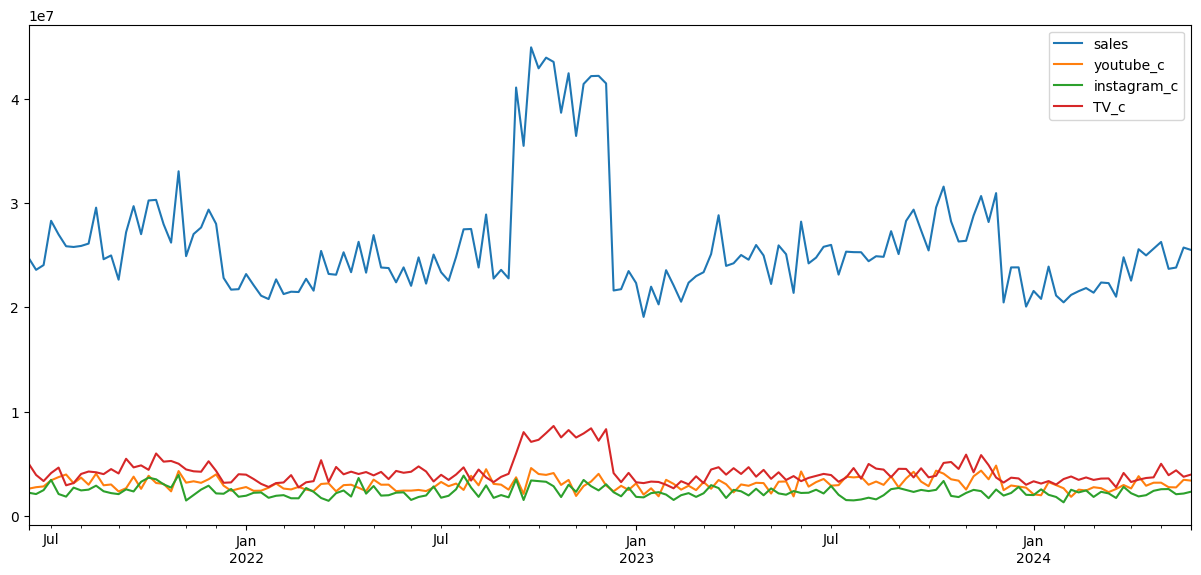

In [ ]:
data[["sales", "youtube_c", "instagram_c", "TV_c"]].plot(figsize=(15, 6.5))

**Fit models**

In [ ]:
res = dict()

In [ ]:
mod = sm.OLS(data[["sales"]], sm.add_constant(data[["youtube_c", "instagram_c", "TV_c"]]))
res['channels'] = mod.fit()

In [ ]:
mod = sm.OLS(data[["sales"]], sm.add_constant(data[["youtube_c", "instagram_c", "TV_c", "Q1_dummy", "Q2_dummy", "Q3_dummy"]]))
res['channels-season'] = mod.fit()

In [ ]:
mod = sm.OLS(data[["sales"]], sm.add_constant(data[["youtube_c", "instagram_c", "TV_c", "Q1_dummy", "Q2_dummy", "Q3_dummy", "football_worldcup_campaign"]]))
res['channels-season-cup'] = mod.fit()

In [ ]:
mod = sm.OLS(data[["sales"]], sm.add_constant(data[["youtube_c", "instagram_c", "TV_c", "Q1_dummy", "Q2_dummy", "Q3_dummy", "football_worldcup_campaign", "price_index"]]))
res['channels-season-cup-price'] = mod.fit()

In [ ]:
mod = sm.OLS(data[["sales"]], sm.add_constant(data[["youtube_c", "instagram_c", "TV_c", "Q1_dummy", "Q2_dummy", "Q3_dummy", "football_worldcup_campaign", "price_index", "website_visits"]]))
res['channels-season-cup-price-visits'] = mod.fit()

In [ ]:
model_specs = ["channels", "channels-season", "channels-season-cup","channels-season-cup-price","channels-season-cup-price-visits"]
result_dict = dict()
for spec in model_specs:
  result_dict[spec] = dict()
  result_dict[spec]['estimates'] =  res[spec].params[['youtube_c', 'instagram_c', 'TV_c']].transpose().to_numpy()
  result_dict[spec]['conf_int'] =  res[spec].bse.loc[['youtube_c', 'instagram_c', 'TV_c']].transpose().to_numpy()

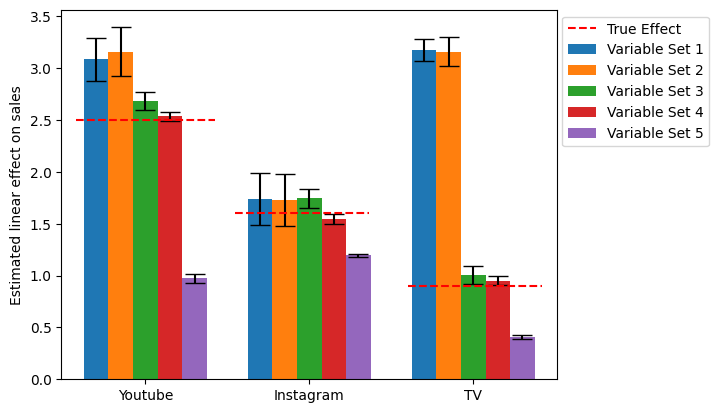

In [ ]:
  # width of the bars
  barWidth = 0.3

  # The x position of bars
  r1 = np.arange(3)*2
  r2 = [x + barWidth for x in r1]
  r3 = [x + barWidth for x in r2]
  r4 = [x + barWidth for x in r3]
  r5 = [x + barWidth for x in r4]
  r6 = [x + barWidth for x in r5]

  # Create blue bars
  plt.bar(r1, result_dict['channels']['estimates'], width = barWidth, yerr=result_dict['channels']['conf_int'], capsize=7, label='Variable Set 1')
  plt.bar(r2, result_dict['channels-season']['estimates'], width = barWidth, yerr=result_dict['channels-season']['conf_int'], capsize=7, label='Variable Set 2')
  plt.bar(r3, result_dict['channels-season-cup']['estimates'], width = barWidth, yerr=result_dict['channels-season-cup']['conf_int'], capsize=7, label='Variable Set 3')
  plt.bar(r4, result_dict['channels-season-cup-price']['estimates'], width = barWidth, yerr=result_dict['channels-season-cup-price']['conf_int'], capsize=7, label='Variable Set 4')
  plt.bar(r5, result_dict['channels-season-cup-price-visits']['estimates'], width = barWidth, yerr=result_dict['channels-season-cup-price-visits']['conf_int'], capsize=7, label='Variable Set 5')
  plt.axhline(y=2.5, xmin = 0.03, xmax = 0.31, color='r', linestyle='--', label='True Effect')
  plt.axhline(y=1.6, xmin = 0.35, xmax = 0.62, color='r', linestyle='--')
  plt.axhline(y=0.9, xmin = 0.7, xmax = 0.97, color='r', linestyle='--')
  # general layout
  plt.xticks([r*2 + 2*barWidth for r in range(3)], ['Youtube', 'Instagram', 'TV'])
  plt.ylabel('Estimated linear effect on sales')
  plt.legend( bbox_to_anchor=(1.32, 1), loc='upper right')

  # Show graphic
  plt.show()